2022-04-23 18:46:55,187 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 2s, Rate: 6.7e+01/s
2022-04-23 18:46:55,274 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 1.3e+02/s
2022-04-23 18:46:55,367 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 0s, Remaining: 1s, Rate: 1.3e+02/s
2022-04-23 18:46:55,458 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 0s, Remaining: 1s, Rate: 1.4e+02/s
2022-04-23 18:46:55,549 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 0s, Remaining: 1s, Rate: 1.4e+02/s
2022-04-23 18:46:55,639 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2022-04-23 18:46:55,731 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+02/s
2022-04-23 18:46:55,821 subsystems 0/1 INFO :: Building subprobl

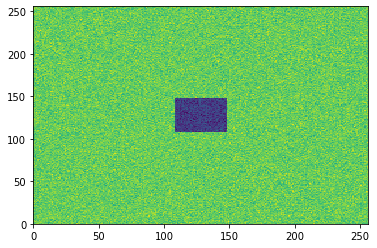

In [167]:
"""
Dedalus script simulating the 1D Korteweg-de Vries / Burgers equation.
This script demonstrates solving a 1D initial value problem and produces
a space-time plot of the solution. It should take just a few seconds to
run (serial only).

We use a Fourier basis to solve the IVP:
    dt(u) + u*dx(u) = a*dx(dx(u)) + b*dx(dx(dx(u)))
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
from matplotlib.animation import FuncAnimation, PillowWriter  
logger = logging.getLogger(__name__)


# Parameters
Lx, Ly = 200, 200
Nx,Ny = 256,256
Da = 0.16
Db=0.08
f=0.06
alpha= 0.062;

dealias = 3/2
stop_sim_time = 20000
D = 0.25
timestepper = d3.RK111
timestep = 10
dtype = np.float64
#alpha = 12.31
#r = 1.52

# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=dealias)

# Fields
a = dist.Field(name='a', bases=(xbasis,ybasis))
b = dist.Field(name='b', bases=(xbasis,ybasis))

# Substitutions
dx = lambda A: d3.Differentiate(A, coords['x'])
#- a.*b.^2 + f*(1-a);
#dbdt = +a.*b.^2 - (f+alpha)*b;
# Problem
problem = d3.IVP([a,b], namespace=locals())
problem.add_equation("dt(a) - Da*lap(a)  = -a*b**2+f*(1-a)")
problem.add_equation("dt(b) - Db*lap(b)  = a*b**2-(f+alpha)*b")
#problem.add_equation("u(x='left')=0")
#problem.add_equation("u(x='right')=0")

# Initial conditions
x = dist.local_grid(xbasis)
y = dist.local_grid(ybasis)
#print(x)

#n = 20
a_mat = np.random.normal(size=(len(x), len(x)))*0.05+1
b_mat = np.random.normal(size=(len(x), len(x)))*0.05
center = int(len(x)/2)
a_mat[center-20:center+20, center-20:center+20] +=  - 0.5
b_mat[center-20:center+20, center-20:center+20] += 0.25
a['g'] = a_mat
b['g'] = b_mat
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time
plt.pcolormesh(a['g'])

In [168]:
# Main loop
a.change_scales(1)
b.change_scales(1)
a_list = [np.copy(a['g'])]
b_list = [np.copy(b['g'])]
#print(a_list)
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 200 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 15 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e saved' %(solver.iteration, solver.sim_time, timestep))
        a.change_scales(1)
        b.change_scales(1)
        a_list.append(np.copy(a['g']))
        b_list.append(np.copy(b['g']))
        t_list.append(solver.sim_time)

2022-04-23 18:47:22,195 __main__ 0/1 INFO :: Iteration=15, Time=1.500000e+02, dt=1.000000e+01 saved
2022-04-23 18:47:22,813 __main__ 0/1 INFO :: Iteration=30, Time=3.000000e+02, dt=1.000000e+01 saved
2022-04-23 18:47:23,434 __main__ 0/1 INFO :: Iteration=45, Time=4.500000e+02, dt=1.000000e+01 saved
2022-04-23 18:47:24,033 __main__ 0/1 INFO :: Iteration=60, Time=6.000000e+02, dt=1.000000e+01 saved
2022-04-23 18:47:24,632 __main__ 0/1 INFO :: Iteration=75, Time=7.500000e+02, dt=1.000000e+01 saved
2022-04-23 18:47:25,237 __main__ 0/1 INFO :: Iteration=90, Time=9.000000e+02, dt=1.000000e+01 saved
2022-04-23 18:47:25,865 __main__ 0/1 INFO :: Iteration=105, Time=1.050000e+03, dt=1.000000e+01 saved
2022-04-23 18:47:26,478 __main__ 0/1 INFO :: Iteration=120, Time=1.200000e+03, dt=1.000000e+01 saved
2022-04-23 18:47:27,090 __main__ 0/1 INFO :: Iteration=135, Time=1.350000e+03, dt=1.000000e+01 saved
2022-04-23 18:47:27,691 __main__ 0/1 INFO :: Iteration=150, Time=1.500000e+03, dt=1.000000e+01 sa

2022-04-23 18:48:09,798 __main__ 0/1 INFO :: Iteration=1170, Time=1.170000e+04, dt=1.000000e+01 saved
2022-04-23 18:48:10,428 __main__ 0/1 INFO :: Iteration=1185, Time=1.185000e+04, dt=1.000000e+01 saved
2022-04-23 18:48:11,066 __main__ 0/1 INFO :: Iteration=1200, Time=1.200000e+04, dt=1.000000e+01
2022-04-23 18:48:11,067 __main__ 0/1 INFO :: Iteration=1200, Time=1.200000e+04, dt=1.000000e+01 saved
2022-04-23 18:48:11,687 __main__ 0/1 INFO :: Iteration=1215, Time=1.215000e+04, dt=1.000000e+01 saved
2022-04-23 18:48:12,305 __main__ 0/1 INFO :: Iteration=1230, Time=1.230000e+04, dt=1.000000e+01 saved
2022-04-23 18:48:12,918 __main__ 0/1 INFO :: Iteration=1245, Time=1.245000e+04, dt=1.000000e+01 saved
2022-04-23 18:48:13,519 __main__ 0/1 INFO :: Iteration=1260, Time=1.260000e+04, dt=1.000000e+01 saved
2022-04-23 18:48:14,115 __main__ 0/1 INFO :: Iteration=1275, Time=1.275000e+04, dt=1.000000e+01 saved
2022-04-23 18:48:14,707 __main__ 0/1 INFO :: Iteration=1290, Time=1.290000e+04, dt=1.000

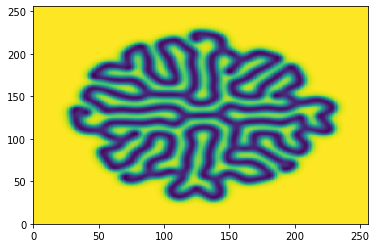

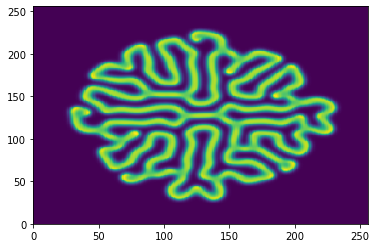

In [164]:
plt.pcolormesh(a['g'])
plt.show()
plt.pcolormesh(b['g'])

2022-04-23 18:48:43,424 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


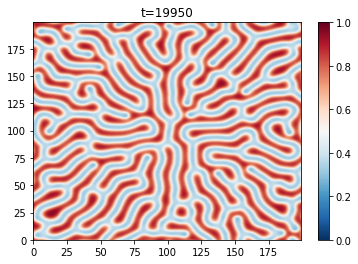

In [169]:
fig, ax = plt.subplots() 
def init():
    plt.pcolormesh(y.ravel(), x.ravel(),a_list[0],cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(0, 1))
    plt.colorbar()
    #ax.set_title(f'Naive SI, t={t_list[0]}')
def update(i):
    plt.clf()
    plt.pcolormesh(y.ravel(), x.ravel(),a_list[i],cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(0, 1))
    plt.colorbar()
    plt.title(f't={t_list[i]}')

ani = FuncAnimation(fig, update, range(0,len(t_list)), init_func=init)
writer = PillowWriter(fps=15)
ani.save(f"gray_scott_periodic_bc.gif", writer=writer)

In [165]:
len(t_list)

51